In [2]:
import pandas as pd
from pathlib import Path
import json
from PIL import Image
from PIL.TiffTags import TAGS
import cv2
import importlib
import matplotlib.pyplot as plt
import segment_tiles as st
import load_data as ld
from matplotlib import patches

In [3]:
with open('config.json', 'r') as f:
    config = json.load(f)
config

{'xy_dir': '/Users/akre96/Data/BE_224B/new_aggregate_data/xy',
 'coord_img_dir': '/Users/akre96/Data/BE_224B/new_aggregate_data/imgs',
 'limbal_img_dir': '/Users/akre96/Data/BE_224B/Density Research Lab 18 samples',
 'bcd_dir': '/Users/akre96/Data/BE_224B/Central BCD2',
 'bcd_metadata': '/Users/akre96/Data/BE_224B/Central BCD2/LSCD grading2.xlsx'}

['D3 R3',
 'D2 R3',
 'D3 R1',
 'D2 R1',
 'D3 R5',
 'D2 R5',
 'D3 R2',
 'D2 R2',
 'D3 R6',
 'D2 R6',
 'D3 R4',
 'D2 R4',
 'D1 R5',
 'D1 R1',
 'D1 R3',
 'D1 R4',
 'D1 R6',
 'D1 R2']

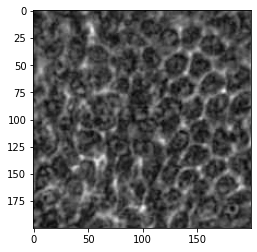

In [4]:
importlib.reload(ld)
subs = ld.get_lsc_subjects()
test_img = ld.get_lsc_image(
    'D2 R1',
    get_tile=True
)
plt.imshow(test_img, cmap='gray')
subs

In [5]:
coord_imgs = Path(config['coord_img_dir'])
xy = Path(config['xy_dir'])

In [6]:
# Get an image with coordinates
for f in xy.iterdir():
    if f.name.endswith('.csv'):
        coords = pd.read_csv(f)
        coords['file']=f.name
        img_f = Path(coord_imgs, f.name.split('.')[0] + '.tif')
        break

In [7]:
# Find scale/density of an image
with Image.open(img_f) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}
xres = meta_dict['XResolution']
yres = meta_dict['YResolution']
scalex = xres[0][0]/xres[0][1]
scaley = yres[0][0]/yres[0][1]

width = meta_dict['ImageWidth'][0]/scalex
height = meta_dict['ImageLength'][0]/scaley
density = 1000**2 * coords.shape[0]/(width*height)

print('Scale (microns):', width, height)
print('Density (cells/mm^2):', density)

Scale (microns): 147.05893166097917 147.05893166097917
Density (cells/mm^2): 4855.192860002625


In [8]:
# Load a few full slide images from a folder
ims = []
for d in Path(config['limbal_img_dir']).iterdir():
    if d.is_dir():
        for f in d.iterdir():
            if f.name.endswith('.jpg'):
                
                img = cv2.imread(f.as_posix(), cv2.IMREAD_GRAYSCALE)
                ims.append(img)
        break
print("Num images:", len(ims))

Num images: 8


Quick Convolution: 100%|██████████| 50/50 [00:00<00:00, 1445.41it/s]


Plotting output


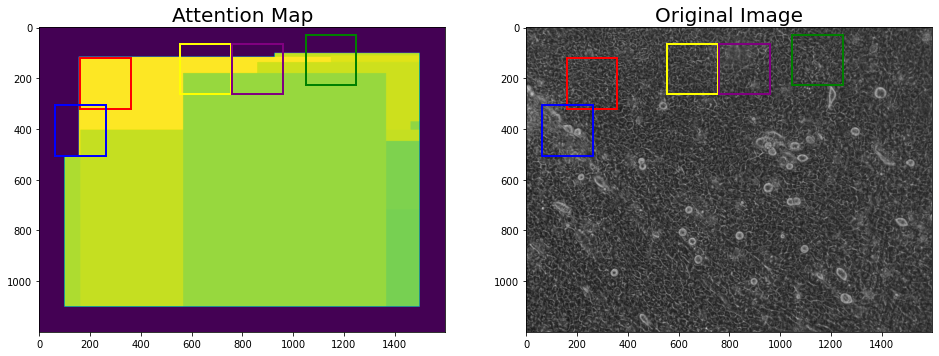

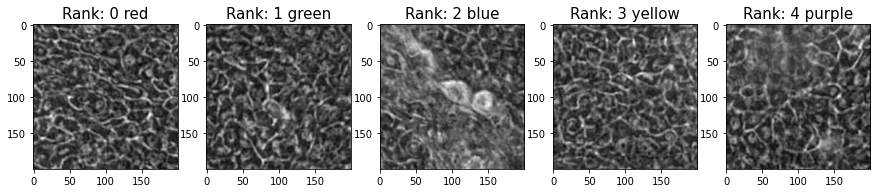

In [10]:
# Run Full Tile Segmentation pipeline
importlib.reload(st)
tilesegmenter = st.TileSegmenter(n_tiles=5, tile_size=200, glcm_n_samples=50, canny_sigma=2, plot_patches=True, show_tqdm=True)
patches = tilesegmenter.segment_tiles(ims[7])

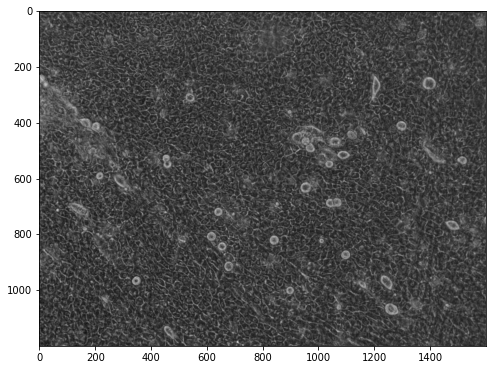

In [17]:
img_2 = ims[7]
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img_2 , cmap='gray')

In [11]:
import importlib
importlib.reload(st)
n_samples = 5000
[contrast_mat, energy_mat], xys = st.get_greycoprop_matrices(img_2, n_samples)

100%|██████████| 5000/5000 [00:08<00:00, 594.65it/s]


0.0 1.0


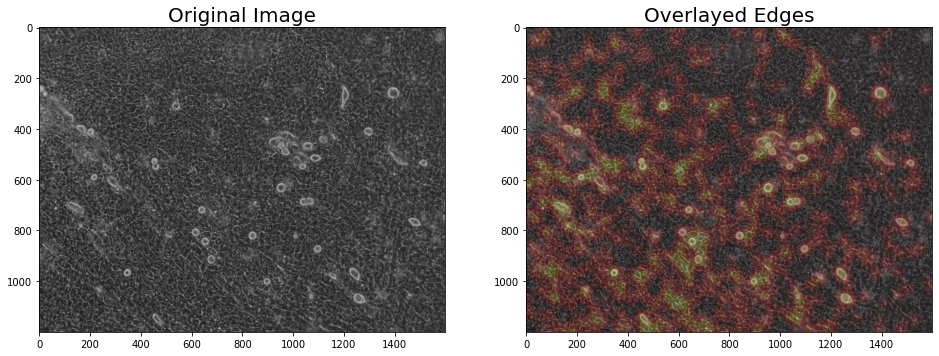

In [23]:
from skimage.morphology import dilation, disk
from skimage import exposure
from skimage.feature import canny
from skimage.filters import rank

dilated = dilation(canny(img_2, sigma = 2), disk(5))
smooth_edge = st.min_max_normalize(rank.mean(dilated, selem=disk(25)))
                
fig, axes = plt.subplots(ncols=2, figsize=(2*8,8))
ax = axes[0]                
ax.imshow(img_2, cmap='gray')
ax.set_title('Original Image', fontsize=20)

ax=axes[1]
ax.imshow(img_2, cmap='gray')
ax.imshow(smooth_edge, alpha = 0.2, cmap='hot')
ax.set_title('Overlayed Edges', fontsize=20)

print(smooth_edge.min(), smooth_edge.max())

Energy...
Contrast...


Quick Convolution:  23%|██▎       | 1151/5000 [00:00<00:00, 11506.66it/s]

Summing...
Convolving...


Quick Convolution: 100%|██████████| 5000/5000 [00:00<00:00, 11011.74it/s]


Plotting...
4.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


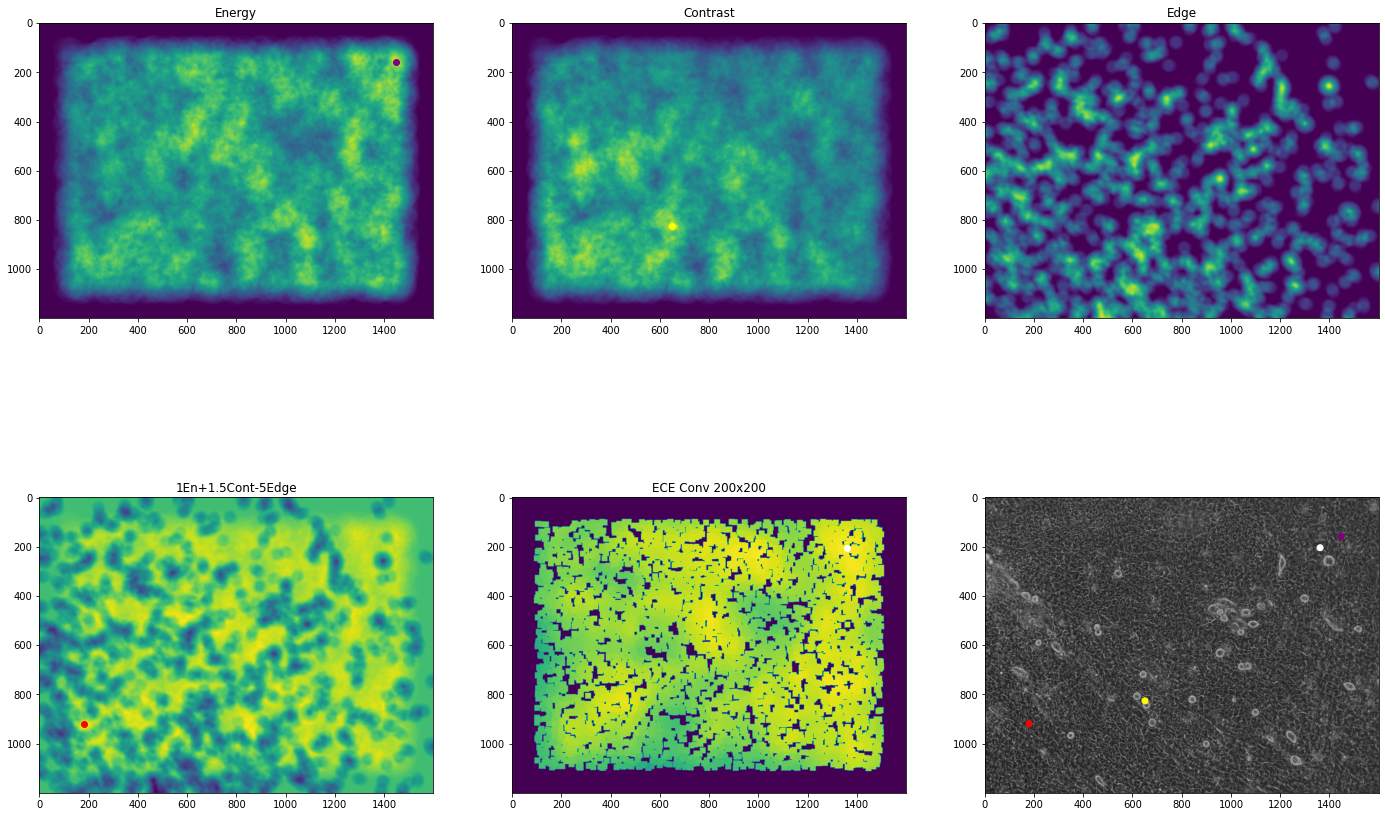

In [52]:
%%timeit -r 1 -n 1
from scipy.ndimage import convolve

print('Energy...')
smooth_energy = dilation(st.min_max_normalize(energy_mat), selem=disk(5))
smooth_energy = st.min_max_normalize(rank.mean(smooth_energy, selem=disk(50)))

print('Contrast...')
smooth_contrast = dilation(st.min_max_normalize(contrast_mat), selem=disk(5))
smooth_contrast = st.min_max_normalize(rank.mean(smooth_contrast, selem=disk(50)))

print('Summing...')
sum_mat = 1.5*smooth_contrast + smooth_energy - 5*(smooth_edge)

print('Convolving...')
attention_mat = st.quick_conv_sum(sum_mat, n_samples, xys)

print('Plotting...')
fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(8*3,8*2))

ax = axes[0][0]
ax.set_title('Energy')
ax.imshow(smooth_energy)

y_e, x_e = np.unravel_index(np.argmax(smooth_energy), img_2.shape)
ax.scatter(x_e,y_e,c='purple')

ax = axes[0][1]
ax.set_title('Contrast')
ax.imshow(smooth_contrast)
y_c, x_c = np.unravel_index(np.argmax(smooth_contrast), img_2.shape)
ax.scatter(x_c,y_c,c='yellow')

ax = axes[0][2]
ax.set_title('Edge')
ax.imshow(smooth_edge)


ax = axes[1][0]
ax.set_title('1En+1.5Cont-5Edge')
ax.imshow(sum_mat)
y_s, x_s = np.unravel_index(np.argmax(sum_mat), img_2.shape)
ax.scatter(x_s,y_s,c='red')

ax = axes[1][1]
ax.set_title('ECE Conv 200x200')
ax.imshow(attention_mat)
y, x = np.unravel_index(np.argmax(attention_mat), img_2.shape)
ax.scatter(x,y,c='white')

ax = axes[1][2]
ax.imshow(img_2, cmap='gray')
ax.scatter([x_s, x_e, x_c, x],[y_s, y_e, y_c, y],c=['red', 'purple', 'yellow', 'white'])

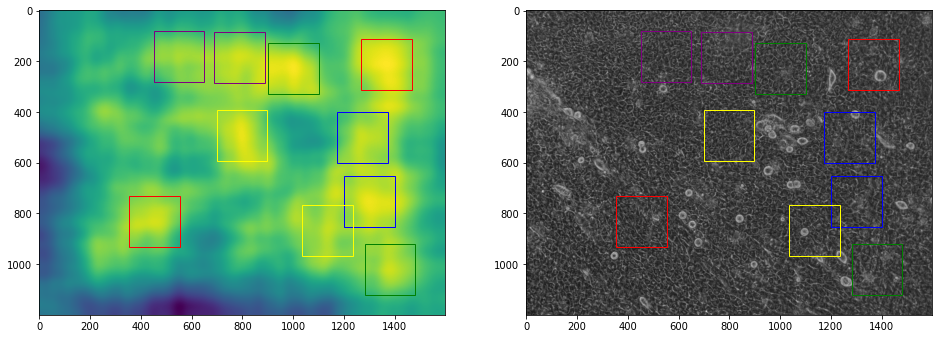

In [87]:
importlib.reload(st)

fig, axes = plt.subplots(ncols=2,figsize=(16,8))
min_dist = 200
xys_2 = st.get_top_xy(attention_mat,n=10, min_dist=min_dist)
ec = ['red', 'green', 'blue', 'yellow', 'purple'] * 2

ax = axes[0]
ax.imshow(attention_mat)
for i, p in enumerate(xys_2):
    x, y = p
    rect = patches.Rectangle((x-100,y-100),200,200,linewidth=1,edgecolor=ec[i],facecolor='none')
    ax.add_patch(rect)
#ax.scatter(x,y,c='gray')

ax = axes[1]
ax.imshow(img_2, cmap='gray')
for i, p in enumerate(xys_2):
    x, y = p
    rect = patches.Rectangle((x-100,y-100),200,200,linewidth=1,edgecolor=ec[i],facecolor='none')
    ax.add_patch(rect)
#ax.scatter(x,y,c='gray')

[ 22350  20750  22349 ... 872874 636905 636904]


636904